# Intro

In this notebook, we will learn about precision-recall curves.

# Simulate data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import namedtuple
from scipy.stats import multivariate_normal
import warnings

warnings.filterwarnings('ignore')
np.random.seed(37)

MVN = namedtuple('MVN', 'mean cov')
DATA = namedtuple('DATA', 'X, y')

mvn0 = MVN(np.array([1.5, 2.5, 3.3]), np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]))
mvn1 = MVN(np.array([1.7, 2.9, 3.0]), np.array([[1.0, 0.5, 0.2], [0.5, 1.0, 2.0], [0.2, 2.0, 1.0]]))

N = 10000
X0 = np.array([multivariate_normal.rvs(mvn0.mean, mvn0.cov) for _ in range(N)])
X1 = np.array([multivariate_normal.rvs(mvn1.mean, mvn1.cov) for _ in range(N)])
y0 = np.full((N, 1), 0, dtype=np.int32)
y1 = np.full((N, 1), 1, dtype=np.int32)

X = np.vstack([X0, X1])
y = np.vstack([y0, y1])

T = DATA(X, y)

N = 25
X0 = np.array([multivariate_normal.rvs(mvn0.mean, mvn0.cov) for _ in range(N)])
X1 = np.array([multivariate_normal.rvs(mvn1.mean, mvn1.cov) for _ in range(N)])
y0 = np.full((N, 1), 0, dtype=np.int32)
y1 = np.full((N, 1), 1, dtype=np.int32)

X = np.vstack([X0, X1])
y = np.vstack([y0, y1])

V = DATA(X, y)

# Learn a classifier

In [2]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=37)
rf_model.fit(T.X, T.y)

y_pred = rf_model.predict_proba(V.X)[:,1]

outcomes = sorted([(y_t, y_p) for y_t, y_p in zip(V.y[:,0], y_pred)], 
                  key=lambda tup: (-tup[1], -tup[0]))

# Construct the precision-recall curve

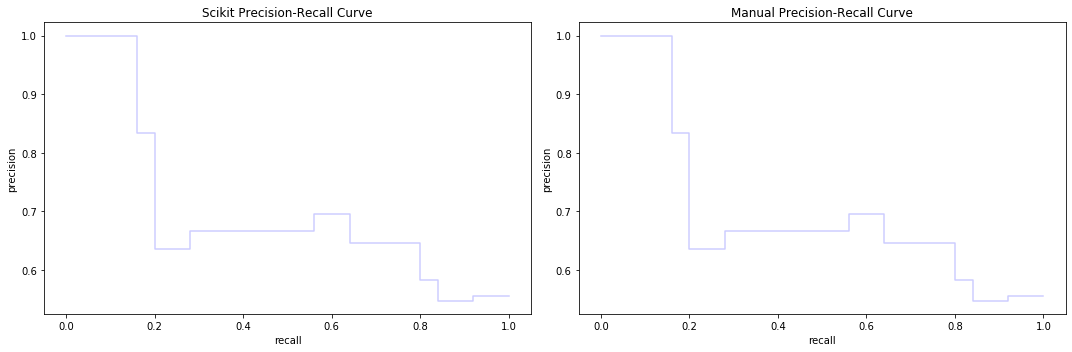

In [3]:
from sklearn.metrics import precision_recall_curve

def get_pr(outcomes, t):
    tp = 0
    fp = 0
    fn = 0

    for y_t, y_p in outcomes:
        clazz_t = int(y_t)
        clazz_p = 1 if y_p >= t else 0
        tp = tp + (1 if clazz_t == 1 and clazz_p == 1 else 0)
        fp = fp + (1 if clazz_t == 0 and clazz_p == 1 else 0)
        fn = fn + (1 if clazz_t == 1 and clazz_p == 0 else 0)

    pre = tp / (tp + fp)
    rec = tp / (tp + fn)
    return pre, rec

def get_prs(outcomes, thresholds=np.linspace(0.2, 1, 9)):
    pres = []
    recs = []
    thrs = []
    for t in thresholds:
        pre, rec = get_pr(outcomes, t)
        pres.append(pre)
        recs.append(rec)
        thrs.append(t)
    pres.append(1.0)
    recs.append(0.0)
    return np.array(pres), np.array(recs), np.array(thrs)

pre_m, rec_m, _ = get_prs(outcomes, thresholds=np.linspace(0.2, 1, 100))
pre_s, rec_s, _ = precision_recall_curve(V.y, y_pred)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].step(rec_s, pre_s, color='b', alpha=0.2, where='post')
ax[0].set_xlabel('recall')
ax[0].set_ylabel('precision')
ax[0].set_title('Scikit Precision-Recall Curve')

ax[1].step(rec_m, pre_m, color='b', alpha=0.2, where='post')
ax[1].set_xlabel('recall')
ax[1].set_ylabel('precision')
ax[1].set_title('Manual Precision-Recall Curve')

plt.tight_layout()

# Integrate the precision-recall curve (using trapezoid method)

In [4]:
from sklearn.metrics import average_precision_score

def get_apr(pre, rec):
    x = np.flip(rec)
    y = np.flip(pre)
    return np.trapz(y, x)

apr = average_precision_score(V.y, y_pred)
apr_s = get_apr(pre_s, rec_s)
apr_m = get_apr(pre_m, rec_m)

print('apr = {:.5f}, apr_s = {:.5f}, apr_m = {:.5f}'.format(apr, apr_s, apr_m))

apr = 0.70137, apr_s = 0.71357, apr_m = 0.71357


# Integrate the precision-recall curve (using weighted average)

In [5]:
def get_apr(pre, rec):
    x = np.flip(rec)
    y = np.flip(pre)
    
    total = 0
    for i in range(len(x)):
        r_c = x[i]
        r_p = x[i if i - 1 < 0 else i - 1]
        p_i = y[i]
        a = (r_c - r_p) * p_i
        total = total + a
    return total

apr_s = get_apr(pre_s, rec_s)
apr_m = get_apr(pre_m, rec_m)

print('apr = {:.5f}, apr_s = {:.5f}, apr_m = {:.5f}'.format(apr, apr_s, apr_m))

apr = 0.70137, apr_s = 0.70137, apr_m = 0.70137


# Construct the receiver operating characterics (ROC) curve

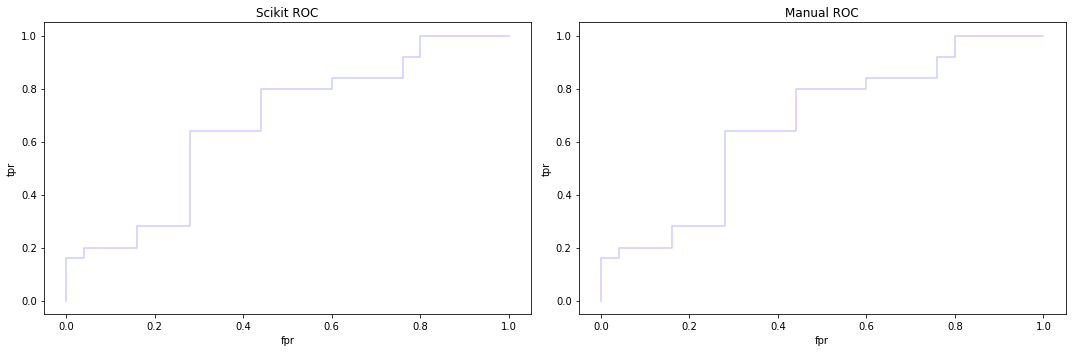

In [6]:
from sklearn.metrics import roc_curve

def get_fpr_tpr(outcomes, t):
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for y_t, y_p in outcomes:
        clazz_t = int(y_t)
        clazz_p = 1 if y_p >= t else 0
        tp = tp + (1 if clazz_t == 1 and clazz_p == 1 else 0)
        fp = fp + (1 if clazz_t == 0 and clazz_p == 1 else 0)
        fn = fn + (1 if clazz_t == 1 and clazz_p == 0 else 0)
        tn = tn + (1 if clazz_t == 0 and clazz_p == 0 else 0)

    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)
    return fpr, tpr

def get_all_fpr_tpr(outcomes, thresholds=np.flip(np.append(np.linspace(0, 1, 11), [2]))):
    fprs = []
    tprs = []
    thrs = []
    for t in thresholds:
        fpr, tpr = get_fpr_tpr(outcomes, t)
        fprs.append(fpr)
        tprs.append(tpr)
        thrs.append(t)
    return np.array(fprs), np.array(tprs), np.array(thrs)

fpr_m, tpr_m, t_m = get_all_fpr_tpr(outcomes, thresholds=np.flip(np.append(np.linspace(0, 1, 100), [2])))
fpr_s, tpr_s, t_s = roc_curve(V.y, y_pred)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].step(fpr_s, tpr_s, color='b', alpha=0.2, where='post')
ax[0].set_xlabel('fpr')
ax[0].set_ylabel('tpr')
ax[0].set_title('Scikit ROC')

ax[1].step(fpr_m, tpr_m, color='b', alpha=0.2, where='post')
ax[1].set_xlabel('fpr')
ax[1].set_ylabel('tpr')
ax[1].set_title('Manual ROC')

plt.tight_layout()

# Integrate the ROC curve (using trapezoid method)

In [7]:
from sklearn.metrics import roc_auc_score

def get_auc(tpr, fpr):
    return np.trapz(tpr, fpr)

auc = roc_auc_score(V.y, y_pred)
auc_s = get_auc(tpr_s, fpr_s)
auc_m = get_auc(tpr_m, fpr_m)

print('auc = {:.5f}, auc_s = {:.5f}, auc_m = {:.5f}'.format(auc, auc_s, auc_m))

auc = 0.71200, auc_s = 0.71200, auc_m = 0.71200


# Links

* https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html